In [2]:
#Diseñar un algoritmo que sea capaz de detectar y dibujar automaticamente las rectas.
 
#Extraer la posicion de las lineas exteriores y la linea central de la cancha en la imagen
#Primero: Eliminar ruido 
#Segundo: Tecnica de busqueda y ajuste de lineas en la imagen. RANSAC, Hough o barrido horizontal o vertical. SOLO SE PERMITE UTILIZAR FUNCIONES PARA RESOLVER SISTEMAS POR MINIMOS CUADRADOS
#Tercero: Non-Max-Suppressio, elegir entre detecciones multiples de la misma recta y definir una deteccion unica entre lineas -analizar el angulo entre las rectas-.

In [3]:
# ! pip install ../cvum
# ! pip install opencv-python
# ! pip install matplotlib
import cv2
import argparse
import numpy as np
from sympy import symbols, solveset, Eq
from cvum.utils import add_snp_noise
from cvum.utils import imread_rgb
from cvum.utils import correlationdot_2D
from sympy.solvers import solve
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import math
import scipy.ndimage as ndimage
import matplotlib.lines as mlines

[[[193.          1.5184364]]

 [[191.          1.5184364]]]
[INFO] angulo: -3.00000


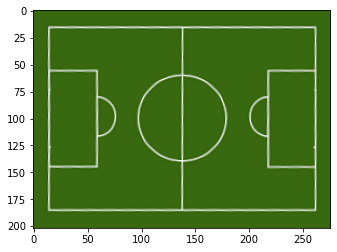

In [4]:
#Enderezar img

img = cv2.imread('./images/football.png') #Cargamos imagen


def estan_cercanos(a1, a2, error):
    cases = np.unwrap([a2-error, a1, a2 + error])
    return cases[0] <= cases[1] <= cases[2]

def enderezar(entrada, salida):
    # Leer la imagen
    imagen = cv2.imread(entrada)

    # Convertirla a gris y detectar bordes
    gray = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
    
    binaria = cv2.Canny(gray,50,150,apertureSize = 3)
    # Usar la transformada de Hough para encontrar líneas
    # en la imagen binarizada, con una resolución de medio
    # grado (pi/720) y quedándose sólo con las líneas que
    # alcancen puntuación de 1000 o más (que serán las
    # más largas)
    lineas = cv2.HoughLines(binaria, 1, np.pi/720, 200)
    print(lineas)
    # Recopilemos qué ángulos ha encontrado la transformada
    # de hough para cada una de las líneas halladas
    angulos = []
    for linea in lineas:
        rho, theta = linea[0]
        if rho<0:
            theta = -theta

        # Quedarse solo con las rayas próximas a la horizontal
        # (con un error de +-10 grados)
        if not estan_cercanos(theta, np.pi/2, np.deg2rad(10)):
           continue;

        angulos.append(theta)

    # Ahora contemos cuántas veces aparece cada ángulo
    from collections import Counter
    veces = Counter(angulos)

    # Quedémonos con los tres casos más frecuentes
    frecuentes = veces.most_common(3)

    # Y calculemos el promedio de esos tres casos
    suma = sum(angulo*repeticion for angulo,repeticion in frecuentes)
    repeticiones = sum(repeticion for angulo, repeticion in frecuentes)
    angulo = suma/repeticiones

    angulo = np.rad2deg(angulo - np.pi/2)
    print("[INFO] angulo: {:.5f}".format(angulo))

    # Ahora enderecemos la imagen, girando el ángulo detectado
    (h, w) = imagen.shape[:2]
    centro = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(centro, angulo, 1.0)

    girada = cv2.warpAffine(imagen, M, (w, h),
                flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Y volcamos a disco el resultado
    cv2.imwrite(salida, girada)

    plt.imshow(girada)



    
enderezar('./images/football.png','./images/derecha.png')


In [5]:
#Luego de tener la imagen recta, hay que detectar lineas, primero eliminamos ruido

0.63 138 101 40


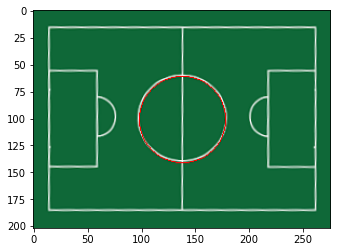

In [91]:
from collections import defaultdict
from PIL import Image, ImageDraw
from math import sqrt, pi, cos, sin

# Load image:
input_image = Image.open("./images/derecha.png")

# Output image:
output_image = Image.new("RGB", input_image.size)
output_image.paste(input_image)
draw_result = ImageDraw.Draw(output_image)

# Find circles
rmin = 30
rmax = 50
steps = 100
threshold = 0.4

points = []
for r in range(rmin, rmax + 1):
    for t in range(steps):
        points.append((r, int(r * cos(2 * pi * t / steps)), int(r * sin(2 * pi * t / steps))))

acc = defaultdict(int)
for x, y in canny_edge_detector(input_image):
    for r, dx, dy in points:
        a = x - dx
        b = y - dy
        acc[(a, b, r)] += 1

circles = []
for k, v in sorted(acc.items(), key=lambda i: -i[1]):
    x, y, r = k
    if v / steps >= threshold and all((x - xc) ** 2 + (y - yc) ** 2 > rc ** 2 for xc, yc, rc in circles):
        print(v / steps, x, y, r)
        circles.append((x, y, r))

for x, y, r in circles:
    draw_result.ellipse((x-r, y-r, x+r, y+r), outline=(255,0,0,0))

# Save output image
output_image.save("./images/circle.png")
plt.imshow(output_image)

In [80]:
def lines_detector(image, edge_image, num_rhos=170, num_thetas=180, t_count=220): # <- estos son los valores a cambiar
    edge_height, edge_width = edge_image.shape[:2]
    edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
    #
    d = np.sqrt(np.square(edge_height) + np.square(edge_width))
    dtheta = 180 / num_thetas
    drho = (2 * d) / num_rhos
    #
    thetas = np.arange(0, 180, step=dtheta)
    rhos = np.arange(-d, d, step=drho)
    #
    cos_thetas = np.cos(np.deg2rad(thetas))
    sin_thetas = np.sin(np.deg2rad(thetas))
    #
    accumulator = np.zeros((len(rhos), len(rhos)))
    #
    figure = plt.figure(figsize=(12, 12))
    #subplot1 = figure.add_subplot(1, 4, 1)
    #subplot1.imshow(image)
    #subplot2 = figure.add_subplot(1, 4, 2)
    #subplot2.imshow(edge_image, cmap="gray")
    subplot3 = figure.add_subplot(1, 4, 3)
    subplot3.set_facecolor((0, 0, 0))
    subplot4 = figure.add_subplot(1, 4, 4)
    subplot4.imshow(image)
    #
    edge_points = np.argwhere(edge_image != 0)
    edge_points = edge_points - np.array([[edge_height_half, edge_width_half]])
    #
    rho_values = np.matmul(edge_points, np.array([sin_thetas, cos_thetas]))
    #
    accumulator, theta_vals, rho_vals = np.histogram2d(np.tile(thetas, rho_values.shape[0]),
                                                       rho_values.ravel(), bins=[thetas, rhos])
    accumulator = np.transpose(accumulator)
    lines = np.argwhere(accumulator > t_count)
    rho_idxs, theta_idxs = lines[:, 0], lines[:, 1]
    r, t = rhos[rho_idxs], thetas[theta_idxs]

    aux = []
    points=[]
    
    for ys in rho_values:
        subplot3.plot(thetas, ys, color="white", alpha=0.05)
    
    subplot3.plot([t], [r], color="yellow", marker='o')
    count_lines = 0
    for line in lines:
        y, x = line
        rho = rhos[y]
        theta = thetas[x]
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))
        x0 = (a * rho) + edge_width_half
        y0 = (b * rho) + edge_height_half
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        subplot3.plot([theta], [rho], marker='o', color="yellow")
        subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))
        aux.append((x1,x2, y1, y2))
        count_lines +=1
    print(f'Amount lines: {count_lines}')
    x, y = symbols('x y')
    i=0
    ecuations = [1]*len(aux)   ## No es el largo de aux

    for line in aux:
        x1, x2, y1, y2 = line
        if (x2 - x1)==0:
            ecuations[i] = x - x1     ## En realidad es ecuations de i
        elif (y2 - y1)==0:
                ecuations[i] = y - y1   ## En realidad es ecuations de i
        else:
            ecuations[i] = ((x-x1)*(y2-y1))/(x2-x1) + y1 - y      ## En realidad es ecuations de i       #x*(y2/val) -x*(y1/val) - x1*(y2/val) + x1*(y1/val) + y1 - y
        i = i+1
    line_pointers = [1]*6
    img_derecha = cv2.imread('./images/derecha.png')
    for e in range(0,len(ecuations)):
        for f in range(e+1,len(ecuations)):
            sol = solve([ecuations[e], ecuations[f]])
            if sol:
                if sol.get(y)>=0:
                    print(sol)
                    points.append(sol)
                    line_pointers = cv2.circle(img_derecha, (sol.get('x'),sol.get('y')), radius=5, color=(0, 51, 153), thickness=-1)               #(sol[x],sol[y])    ASI ESTABA
    

    cv2.imwrite('./images/puntos1.png', line_pointers)
    plt.imshow(line_pointers)
    line_image=image.copy()                                       ##Asi?
    lines_edges = cv2.addWeighted(img, 0.8, line_image, 1, 0)
    
    subplot3.invert_yaxis()
    subplot3.invert_xaxis()

    #subplot1.title.set_text("Original Image")
    #subplot2.title.set_text("Edge Image")
    subplot3.title.set_text("Hough Space")
    subplot4.title.set_text("Detected Lines")
    
    plt.show()

Amount lines: 5
{x: 9441/37, y: 16}
{x: 260542/999, y: 177}
{x: 46142/333, y: 16}
{x: 6136/333, y: 16}
{x: 95987/666, y: 177}
{x: 1775/74, y: 177}


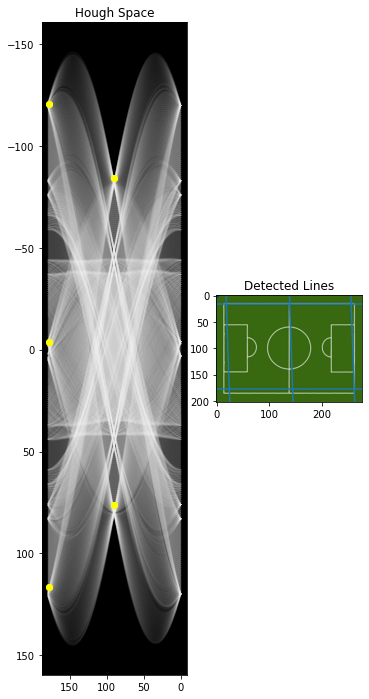

In [81]:
image = cv2.imread('./images/derecha.png')

edge_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
edge_image = cv2.GaussianBlur(edge_image, (7, 7), 5)
edge_image = cv2.Canny(edge_image, 100, 200)

lines_detector(image, edge_image)